In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os 
import sys 
import pandas as pd
import seaborn as sns
from PIL import Image

sys.path.append("C:/Users/cwinklm/Documents/AggroUQ/src/")
%load_ext autoreload
%autoreload 2

from aggrigator.uncertainty_maps import UncertaintyMap
from aggrigator.methods import AggregationMethods as am
from aggrigator.summary import AggregationSummary


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Uncertainty Maps 

In [29]:
data_path = Path("C:/Users/cwinklm/Documents/Data/v1-0-variations_NOISY/variations")
uq_path = Path("C:/Users/cwinklm/Documents/Data/uncertainty_arctique_v1-0-corrected_14/UQ_maps")
all_uq = os.listdir(uq_path)

In [30]:
def get_image_mask_uq(uq_path, data_path, task, variation, data_noise, uq_method, 
                      decomp, uq_idx=None, sample_idx=None, model_noise=0):
    
    """
    return the image, mask and uncertainty map for a given sample index or uncertainty map index.   
    This function is necessary as there is an inconsistency in the naming of the uncertainty maps and the sample indexes.
    """

    map_type = f"{task}_noise_{model_noise}_{variation}_{data_noise}_{uq_method}_{decomp}.npy"
    uq_maps = np.load(uq_path.joinpath(map_type))

    sample_idx_file = f"{task}_noise_{model_noise}_{variation}_{data_noise}_{uq_method}_{decomp}_sample_idx.npy"
    sample_idxs = np.load(str(uq_path).replace("UQ_maps", "UQ_metadata")+"/"+sample_idx_file)

    mask_type = f"{variation}/{data_noise}/masks/{task}_noise_0"
    image_type = f"{variation}/{data_noise}/images" 

    if sample_idx is not None: 
        uq_idx = int(np.where(sample_idxs==sample_idx)[0][0])
    
    else: 
        if uq_idx is None: 
            uq_idx = np.random.randint(0, uq_maps.shape[0])
            sample_idx = sample_idxs[uq_idx]

    uq_map = uq_maps[uq_idx,:,:]

    image = np.array(Image.open(data_path.joinpath(image_type).joinpath(f"img_{sample_idx}.png")))
    mask = np.array(Image.open(data_path.joinpath(mask_type).joinpath(f"{sample_idx}.png")))

    return image, mask, uq_map, sample_idx

## Task 1: Benchmarking UQ methods: 

The goal is to compare 2 or more UQ methods on the *same* data. Ideally we will be able to show that some aggregation methods will identify a strong difference between the methods while other aggregation methods will diminish the difference. In that case we can argue that selecting an appropriate aggregation method is crucial for meaningfully comparing UQ methods. 

Text(0.5, 1.0, 'semantic - blood_cells - 1_00')

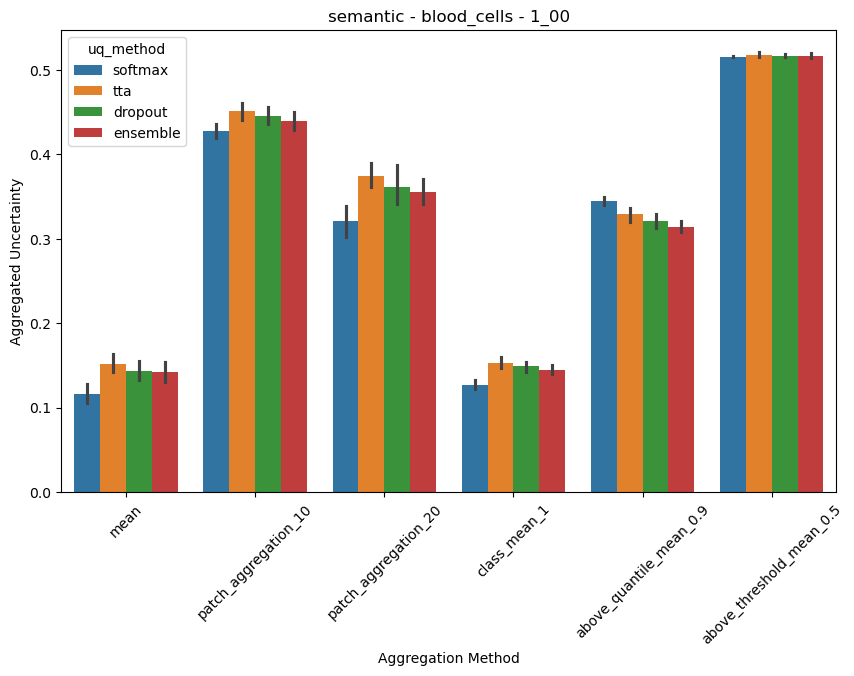

In [31]:
task = "semantic"
model_noise = 0
variation = "blood_cells"
data_noise = "1_00"
uq_methods = ["softmax", "tta", "dropout", "ensemble"]
decomp = "PU"
sample_idx_file = f"{task}_noise_0_{variation}_{data_noise}_{"tta"}_{decomp}_sample_idx.npy"
sample_idx = np.load(str(uq_path).replace("UQ_maps", "UQ_metadata")+"/"+sample_idx_file)

uq_maps, masks, names = [], [], []

for uq_idx, uq_method in enumerate(uq_methods): 

    for idx in sample_idx[:10]:
        img, mask, uq, si = get_image_mask_uq(uq_path, data_path, task, variation, 
                                                    data_noise, uq_method, decomp, uq_idx=4, 
                                                    sample_idx=idx)
        uq_maps.append(uq/np.log(6))
        masks.append(mask)  
        names.append(f"{uq_method}_{str(si)}")


unc_maps = [UncertaintyMap(array=array, mask=mask, name=name) for array, mask, name in zip(uq_maps, masks, names)]

summary = AggregationSummary([(am.mean, None), 
                              (am.patch_aggregation, 10), 
                              (am.patch_aggregation, 20),
                              (am.class_mean, 1),
                              (am.above_quantile_mean, 0.9),
                              (am.above_threshold_mean, 0.5),
                              #(am.max, None), 
                              #(am.morans_I, None), 
                              #(am.gearys_C, None),
                              ])

results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=False)

my_results = results.T.reset_index() 
my_results.columns = my_results.iloc[0]
my_results = my_results[1:]
my_results = my_results.melt(id_vars=['Name'], var_name='AM', value_name='value')
my_results[['uq_method', 'sample']] = my_results['Name'].str.split('_', n=1, expand=True)
my_results.head()


plt.figure(figsize=(10, 6))
sns.barplot(data=my_results, x='AM', y='value', hue='uq_method')
plt.xlabel("Aggregation Method")
plt.xticks(rotation=45)
plt.ylabel("Aggregated Uncertainty")
plt.title(f"{task} - {variation} - {data_noise}")


# Task 2: Measuring Uncertainty

The goal is to see if an uncertainty method pricks up on increasing levels of noise in the data. Here we only look at a single uncertainty method and plot the aggretaed results as a function of noise level. Ideally, we will be able to show that for some aggregation methods we see an increase in uncertainty measured as noise increases while for other aggregation methods the differences will be more subtle or non-existant. 

In [34]:
task = "semantic"
model_noise = 0
variation = "blood_cells"
data_noises = ["0_00", "0_50", "1_00"]
uq_methods = ["softmax", "dropout", "tta", "ensemble"]
decomp = "PU"
sample_idx_file = f"{task}_noise_0_{variation}_{"0_00"}_{"tta"}_{decomp}_sample_idx.npy"
sample_idx = np.load(str(uq_path).replace("UQ_maps", "UQ_metadata")+"/"+sample_idx_file)

uq_maps, masks, names = [], [], []

for um_idx, uq_method in enumerate(uq_methods):

    for dn_idx, data_noise in enumerate(data_noises): 

        for idx in sample_idx[:10]:
            img, mask, uq, si = get_image_mask_uq(uq_path, data_path, task, variation, 
                                                        data_noise, uq_method, decomp, uq_idx=None, 
                                                        sample_idx=idx)
            uq_maps.append(uq/np.log(6))
            masks.append(mask)  
            names.append(f"{data_noise}.{str(si)}.{uq_method}")


In [35]:
unc_maps = [UncertaintyMap(array=array, mask=mask, name=name) for array, mask, name in zip(uq_maps, masks, names)]

summary = AggregationSummary([(am.mean, None), 
                              (am.patch_aggregation, 10), 
                              (am.patch_aggregation, 20),
                              (am.above_quantile_mean, 0.9),
                              (am.above_threshold_mean, 0.5)
                              #(am.class_mean, 1)
                              #(am.max, None), 
                              #(am.morans_I, None), 
                              #(am.gearys_C, None),
                              ])

results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=False)

my_results = results.T.reset_index()
my_results.columns = my_results.iloc[0]
my_results = my_results[1:]
my_results = my_results.melt(id_vars=['Name'], var_name='AM', value_name='value')
my_results[['data_noise', 'sample', 'uq_method']] = my_results['Name'].str.split('.', n=2, expand=True)
my_results['data_noise'] = my_results['data_noise'].str.replace('_', '.').astype(float)
my_results['value'] = my_results['value'].astype(float)
my_results.head()

,Name,AM,value,data_noise,sample,uq_method
0,0_00.308.softmax,mean,0.082937,0.0,308,softmax
1,0_00.235.softmax,mean,0.084356,0.0,235,softmax
2,0_00.309.softmax,mean,0.094910,0.0,309,softmax
3,0_00.254.softmax,mean,0.099105,0.0,254,softmax
4,0_00.312.softmax,mean,0.102140,0.0,312,softmax


In [36]:
import matplotlib.pyplot as plt

In [38]:
summed_results["AM"].unique()

array(['above_quantile_mean_0.9', 'above_threshold_mean_0.5', 'mean',
       'patch_aggregation_10', 'patch_aggregation_20'], dtype=object)

Text(0.5, 0.98, 'semantic - blood_cells')

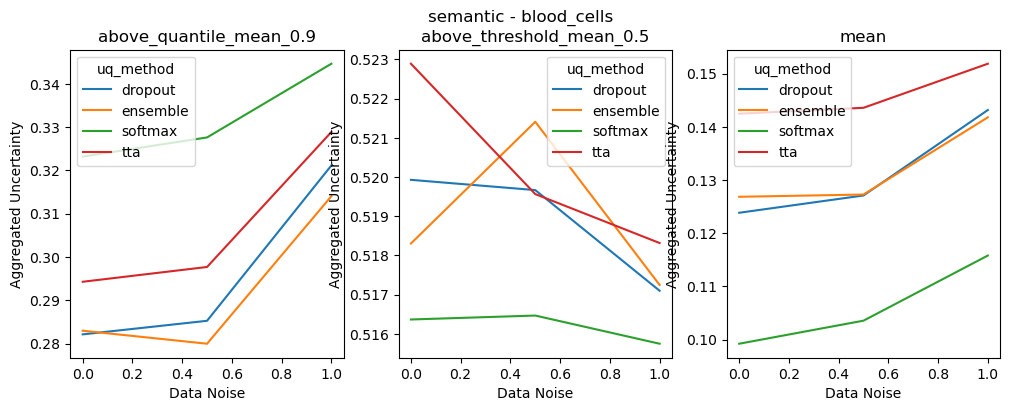

In [42]:
summed_results = my_results.groupby(['data_noise', 'AM', 'uq_method'])["value"].mean().reset_index()
summed_results["value"] = summed_results["value"].to_numpy()

plt.figure(figsize=(12, 4))
for am_idx, ams in enumerate(['above_quantile_mean_0.9', 'above_threshold_mean_0.5', 'mean']): 
    plt.subplot(1, 3, am_idx+1)
    sns.lineplot(data=summed_results[summed_results["AM"]==ams], x='data_noise', y='value',  hue='uq_method')
    plt.xlabel("Data Noise")
    plt.ylabel("Aggregated Uncertainty")
    plt.title(f"{ams}")

plt.suptitle(f"{task} - {variation}")
#sns.lineplot(data=summed_results, x='data_noise', y='value',  hue='uq_method')

# plt.xlabel("Data Noise")
# plt.ylabel("Aggregated Uncertainty")
# plt.title(f"{task} - {variation} - {uq_method}")